In [6]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import rcParams
import warnings
import pandas as pd
warnings.filterwarnings('ignore')

import re
import jax.numpy as jnp
from jax import grad, jit, partial, jacrev
import ticktack
from ticktack import fitting
from tqdm import tqdm
import scipy

rcParams['figure.figsize'] = (8.0, 4.0)

In [7]:
@jit
def sine(t):
    prod =  1.87 + 0.7 * 1.87 * jnp.sin(2 * jnp.pi / 11 * t + jnp.pi/2)
    prod = prod * (t>=cf.start) + (1.87 + 0.18 * 1.87 * jnp.sin(2 * jnp.pi / 11 * cf.start + jnp.pi/2)) * (1-(t>=cf.start))
    return prod

In [12]:
cbm = ticktack.load_presaved_model('Guttler14', production_rate_units = 'atoms/cm^2/s')
cf = fitting.CarbonFitter(cbm)
cf.prepare_function(custom_function=True, f=sine)
cf.time_data = jnp.arange(200, 231)
cf.d14c_data_error = jnp.ones((cf.time_data.size,))
cf.start = np.nanmin(cf.time_data)
cf.end = np.nanmax(cf.time_data)
cf.resolution = 1000
cf.burn_in_time = jnp.linspace(cf.start-1000, cf.start, cf.resolution)
cf.time_grid_fine = jnp.arange(cf.start, cf.end, 0.05)
cf.time_oversample = 1000
cf.offset = 0
cf.annual = jnp.arange(cf.start, cf.end + 1)
cf.mask = jnp.in1d(cf.annual, cf.time_data)[:-1]

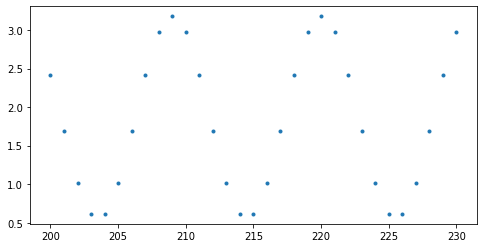

In [13]:
plt.plot(cf.time_data, sine(cf.time_data), ".")

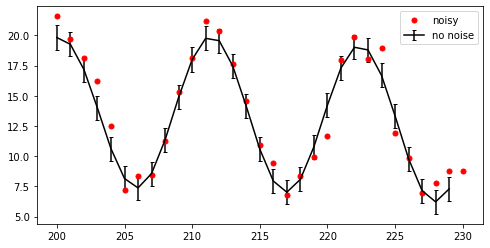

In [32]:
np.random.seed(0)
d14c_data = cf.dc14()
arr = np.array(d14c_data) + np.random.randn(d14c_data.size)
arr = np.append(arr, arr[-1])
plt.errorbar(cf.time_data[:-1], d14c_data, 
             yerr=cf.d14c_data_error[:-1], fmt="-k", 
             fillstyle="none", capsize=2, label="no noise")
plt.plot(cf.time_data, arr, ".r", label="noisy", markersize=10)
plt.legend()

In [25]:
cf.d14c_data = jnp.array(arr)
cf.prepare_function(use_control_points=True, interp='gp')
cf.control_points_time = jnp.arange(cf.start, cf.end, 2)
cf.control_points_time

DeviceArray([200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222,
             224, 226, 228], dtype=int64)

In [26]:
%%time
soln = cf.fit_cp(low_bound=0.)

CPU times: user 1min, sys: 504 ms, total: 1min
Wall time: 59 s


In [27]:
cf.d14c_data.size, cf.d14c_data_error.size

(31, 31)

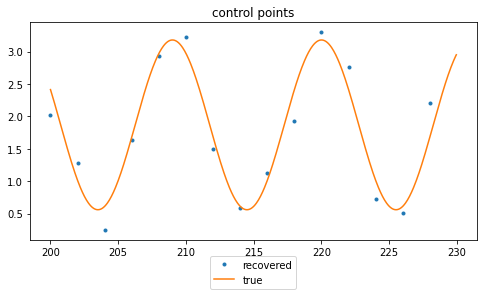

In [30]:
plt.plot(cf.control_points_time, soln.x, ".", label="recovered")
plt.plot(cf.time_grid_fine, sine(cf.time_grid_fine), label='true')
plt.title("control points");
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True)